## Dawid Przybyliński - Algorytmy genetyczne - Lab 3

### Implementacja algorytmu genetycznego do optymalizacji wag sieci MLP

In [296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [555]:
class genetic_MLP:
    
    def __init__(self, structure):
        self.structure = structure
        self.generation_mean = []
    
    def initialize(self, n, init_method = 'uniform -1 1'):
        self.n = n 
        init_method = init_method.split()
        if init_method[0] == 'uniform':
            self.generation_w = [np.array([np.random.uniform(float(init_method[1]),float(init_method[2]),size=(self.structure[i],self.structure[i+1])) for i in range(len(self.structure)-1)]) for i in range(self.n)]
            self.generation_b = [[np.random.uniform(float(init_method[1]),float(init_method[2]),size=(1,self.structure[i+1])) for i in range(len(self.structure)-1)] for i in range(self.n)]
    
    def mlp_forward(self, inputs, weights, biases):
        activations = inputs
        for i in range(len(self.structure)-2):
            output = np.dot(activations, weights[i]) + biases[i]
            activations = 1 / (1 + np.exp(-output))
        result = np.dot(activations, weights[-1]) + biases[-1]
        return result
        
    
    def evolve(self, data, true, epochs=100, p_cross=0.7, p_mutate=0.2, args=False):
        """
        główna funkcja uczenia sieci algorytmem genetycznym
        """
        self.data = data
        self.true = true
        iteration_counter = 0
        current_best_value = -1
        while True:
        
            # check stop condition 
            if iteration_counter == epochs:
                if args:
                    return [self.best[0], self.best[1], 1/self.evaluate(self.best[0], self.best[1])]
                else:
                    return 1/self.evaluate(self.best[0], self.best[1])
            iteration_counter += 1
            print("Epoch: {}/{}".format(iteration_counter,epochs), end='\r')
            
            # crossover
            parent_choice = np.random.choice(self.n, int(np.floor(p_cross*self.n)), replace=False)
            parents_w = []
            parents_b = []
            for choice in parent_choice:
                parents_w.append(self.generation_w[choice])
                parents_b.append(self.generation_b[choice])
            [crossed_w, crossed_b] = self.crossover(parents_w, parents_b)
            
            #population = np.vstack((self.generation, crossed))
            #pop_size = population.shape[0]
            
            # mutation
            mutation_choice = np.random.choice(self.n, int(np.floor(p_mutate*self.n)), replace=False)
            to_mutate_w = []
            to_mutate_b = []
            for choice in mutation_choice:
                to_mutate_w.append(self.generation_w[choice])
                to_mutate_b.append(self.generation_b[choice])
            [mutated_w, mutated_b] = self.mutate(to_mutate_w, to_mutate_b)
            
            population_w = self.generation_w + crossed_w + mutated_w
            population_b = self.generation_b + crossed_b + mutated_b
            
            
            # evaluation
            values = np.asarray([self.evaluate(population_w[i], population_b[i]) for i in range(len(population_w))])
            self.generation_mean.append(np.mean(values))
            
            best_value_index = np.argmax(values)
            if values[best_value_index] > current_best_value:
                self.best = [population_w[best_value_index], population_b[best_value_index]]
                current_best_value = values[best_value_index]
            
            # selection
            prob = values/values.sum()
            choices = np.random.choice([i for i in range(len(population_w))], size=self.n, p=prob)
            self.generation_w = []
            self.generation_b = []
            for choice in choices:
                self.generation_w.append(population_w[choice])
                self.generation_b.append(population_b[choice])
            
    def evaluate(self, w, b):
        pred = self.mlp_forward(self.data, w, b)
        error = mean_squared_error(self.true, pred)
        return 1/error
        
    
    def crossover(self, parents_w, parents_b):
        """
        krzyżowanie
        """
        children_w = []
        children_b = []
        
        for i in range(0, len(parents_w)-1, 2):
            
            split = np.random.randint(len(parents_w[i])-1)
            
            child_1_w = []
            child_2_w = []
            
            child_1_b = []
            child_2_b = []
            
            for j in range(len(parents_b[i])):
                if j <= split:
                    child_1_w.append(parents_w[i][j])
                    child_2_w.append(parents_w[i+1][j])
                    
                    child_1_b.append(parents_b[i][j])
                    child_2_b.append(parents_b[i+1][j])
                else:
                    child_1_w.append(parents_w[i+1][j])
                    child_2_w.append(parents_w[i][j])
                    
                    child_1_b.append(parents_b[i+1][j])
                    child_2_b.append(parents_b[i][j])
                    
            
            children_w.append(child_1_w)
            children_w.append(child_2_w)
            
            children_b.append(child_1_b)
            children_b.append(child_2_b)
            
        return [children_w, children_b]

    
    def mutate(self, pop_w, pop_b):
        mutated_w = []
        mutated_b = []
        for i in range(len(pop_w)):
            w = pop_w[i]
            b = pop_b[i]
            
            mutated_w.append([elem + np.random.normal(0,1,size=(elem.shape[0],elem.shape[1])) for elem in w])
            mutated_b.append([elem + np.random.normal(0,1,size=(elem.shape[0],elem.shape[1])) for elem in b])
        
        return [mutated_w, mutated_b]
        
        
        

### Zbiór Iris
Na początku przebadamy działanie algorytmu na zbiorze iris. 

In [539]:
iris = pd.read_csv("datasets/mio3/iris.data", header=None)

In [540]:
iris

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [541]:
iris_x = np.asarray(iris.iloc[:,0:4])
iris_y = np.asarray(iris.iloc[:,4])
iris_y = np.unique(iris_y, return_inverse=True)[1]

In [542]:
iris_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

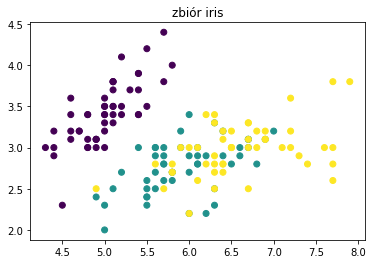

In [543]:
plt.scatter(iris.iloc[:,0], iris.iloc[:,1], c=iris_y)
plt.title("zbiór iris")
plt.show()

In [544]:
q = genetic_MLP([4,3,2,1])
q.initialize(50)
q.evolve(iris_x,iris_y, epochs=500)

0.0765709632521182

Text(0.5, 1.0, 'MSE dla kolejnych epok')

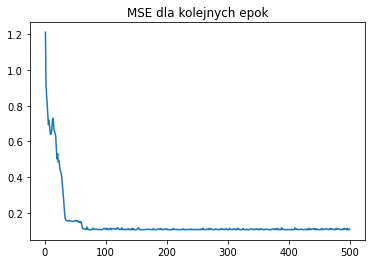

In [545]:
plt.plot(np.linspace(1,500,500), [1/i for i in q.generation_mean])
plt.title('MSE dla kolejnych epok')
plt.show()

Błąd jest bardzo mały, zatem zaokrąglając otrzymane liczby otrzymamy dobry klasyfikator - o ile się nie przeucza. Warto jednak to sprawdzić, dlatego teraz będziemy dzilić zbiór na treningowy i testowy.

In [547]:
X_train, X_test, y_train, y_test = train_test_split(iris_x, iris_y, test_size=0.3, random_state=42)

In [549]:
y_train

array([1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1,
       2, 0, 1, 2, 0, 2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0, 0,
       1, 1, 2, 1, 2, 2, 1, 0, 0, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 1,
       2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2, 0,
       2, 0, 1, 2, 2, 1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 1, 2])

In [556]:
q = genetic_MLP([4,3,2,1])
q.initialize(50)
result = q.evolve(X_train, y_train, epochs=500, args = True)

In [558]:
result[2]

0.09691994051637655

In [581]:
preds_train = q.mlp_forward(X_train, q.best[0], q.best[1])
preds_test = q.mlp_forward(X_test, q.best[0], q.best[1])

In [582]:
print("Train accuracy: {}".format(accuracy_score(y_train, np.round(preds_train.flatten()).astype(int))))
print("Test accuracy: {}".format(accuracy_score(y_test, np.round(preds_test.flatten()).astype(int))))

Train accuracy: 0.8571428571428571
Test accuracy: 0.9777777777777777


Jak widać algorytm radzi sobie bardzo dobrze, pomimo podziału małego zbioru na treningowy i testowy.

## Zbiór Multimodal Large

In [591]:
train = pd.read_csv("datasets/regression/multimodal-large-training.csv", index_col = 0)
test = pd.read_csv("datasets/regression/multimodal-large-test.csv", index_col = 0)

In [592]:
train

,x,y
1,-0.685726,-80
2,-0.879898,-80
3,1.411932,80
4,1.688954,160
5,-0.573238,-80
...,...,...
9996,-0.194391,0
9997,1.012924,80
9998,0.569789,80
9999,0.538241,80


In [599]:
X_train = np.asarray(train.iloc[:,0]).reshape(-1,1)
y_train = np.asarray(train.iloc[:,1]).reshape(-1,1)
X_test = np.asarray(test.iloc[:,0]).reshape(-1,1)
y_test = np.asarray(test.iloc[:,1]).reshape(-1,1)

In [601]:
X_train

array([[-0.68572568],
       [-0.87989777],
       [ 1.41193195],
       ...,
       [ 0.56978928],
       [ 0.53824098],
       [-0.39094106]])

In [604]:
q = genetic_MLP([1,8,1])
q.initialize(50)
result = q.evolve(X_train, y_train, epochs=2000, args = True)

In [607]:
result[2]

174.32272696894387

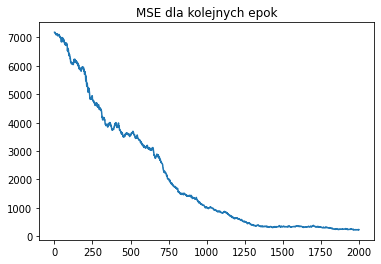

In [605]:
plt.plot(np.linspace(1,2000,2000), [1/i for i in q.generation_mean])
plt.title('MSE dla kolejnych epok')
plt.show()

In [608]:
preds_train = q.mlp_forward(X_train, q.best[0], q.best[1])
preds_test = q.mlp_forward(X_test, q.best[0], q.best[1])

In [612]:
print("Train MSE: {}".format(mean_squared_error(y_train,preds_train)))
print("Test MSE: {}".format(mean_squared_error(y_test,preds_test)))

Train MSE: 174.32272696894387
Test MSE: 181.2306434507398


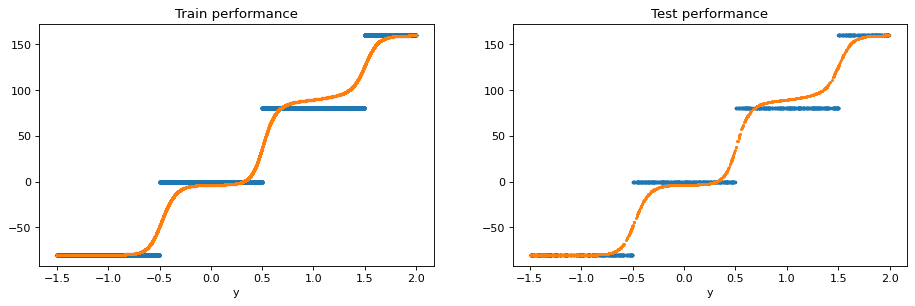

In [624]:
plt.figure(figsize=(14, 4), dpi=80)
plt.subplot(121)
plt.scatter(X_train, y_train, s=5)
plt.scatter(X_train, preds_train, s=3)
plt.xlabel("x")
plt.xlabel("y")
plt.title("Train performance")
plt.subplot(122)
plt.scatter(X_test, y_test, s=5)
plt.scatter(X_test, preds_test, s=3)
plt.xlabel("x")
plt.xlabel("y")
plt.title("Test performance")
plt.show()

## Zbiór auto-mpg

In [654]:
auto = pd.read_csv("datasets/mio3/auto-mpg.data", sep=" ", header=None)

In [655]:
auto

,0,1,2,3,4,5,6,7
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790.0,15.6,82,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,2
389,32.0,4,135.0,84.0,2295.0,11.6,82,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [656]:
auto[2] = auto[2]/100
auto[3] = auto[3]/10
auto[4] = auto[4]/1000
auto[5] = auto[5]/10
auto[6] = auto[6]/10

In [657]:
auto

,0,1,2,3,4,5,6,7
0,18.0,8,3.07,13.0,3.504,1.20,7.0,1
1,15.0,8,3.50,16.5,3.693,1.15,7.0,1
2,18.0,8,3.18,15.0,3.436,1.10,7.0,1
3,16.0,8,3.04,15.0,3.433,1.20,7.0,1
4,17.0,8,3.02,14.0,3.449,1.05,7.0,1
...,...,...,...,...,...,...,...,...
387,27.0,4,1.40,8.6,2.790,1.56,8.2,1
388,44.0,4,0.97,5.2,2.130,2.46,8.2,2
389,32.0,4,1.35,8.4,2.295,1.16,8.2,1
390,28.0,4,1.20,7.9,2.625,1.86,8.2,1


In [658]:
auto_x = np.asarray(auto.iloc[:,1:])
auto_y = np.asarray(auto.iloc[:,0])

In [659]:
X_train, X_test, y_train, y_test = train_test_split(auto_x, auto_y, test_size=0.3, random_state=42)

In [660]:
q = genetic_MLP([7,10,5,1])
q.initialize(30)
result = q.evolve(X_train, y_train, epochs=500, args = True)

In [663]:
result[2]

19.62128518715816

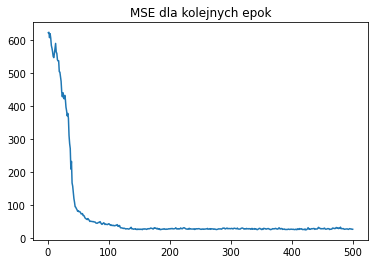

In [664]:
plt.plot(np.linspace(1,500,500), [1/i for i in q.generation_mean])
plt.title('MSE dla kolejnych epok')
plt.show()

In [665]:
preds_train = q.mlp_forward(X_train, q.best[0], q.best[1])
preds_test = q.mlp_forward(X_test, q.best[0], q.best[1])

In [666]:
print("Train MSE: {}".format(mean_squared_error(y_train,preds_train)))
print("Test MSE: {}".format(mean_squared_error(y_test,preds_test)))

Train MSE: 19.62128518715816
Test MSE: 19.365616492852087


### Wnioski
No działa